In [8]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data

Okay, just try verbatim what they're doing and see if it helps

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


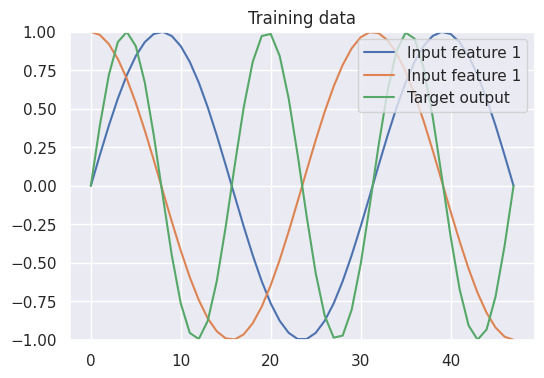

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)

data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [10]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [11]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = CfC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

/home/tristongrayston/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


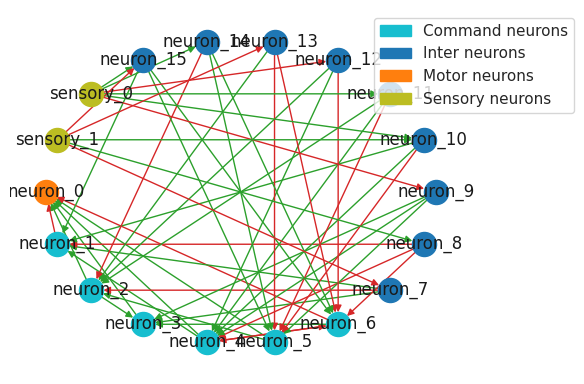

In [12]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()# Let's visualize how LTC initialy performs before the training
sns.set()

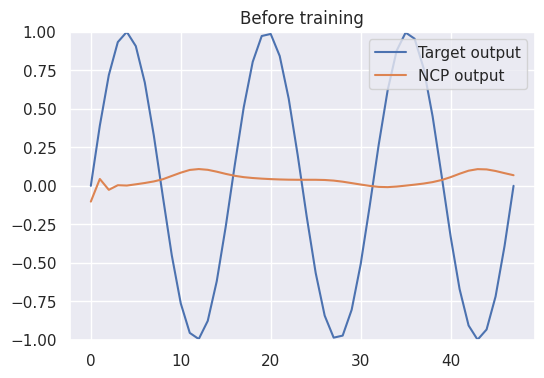

In [13]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [14]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.0 K  | train
---------------------------------------
848       Trainable params
196       Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=400` reached.


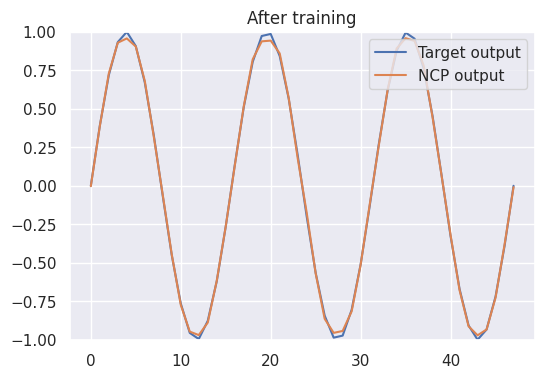

In [15]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# Test 2: Lotka–Volterra Predator–Prey Model

In [27]:
a = 1.1
b = 0.4 
g = 0.4
d = 0.1

y0 = [10, 1]
time = np.linspace(0, 50, 100)
params = (a, b, d, g)

In [55]:
def sim(variables, time, params):
    x = variables[0] # prey pop level
    y = variables[1] # pred pop level

    a, b, d, g = params
    
    dxdt = a*x - b*x*y
    dydt = d*x*y - g*y

    return [dxdt, dydt]

In [65]:
from scipy.integrate import odeint
y = odeint(sim, y0, time, args=(params,))
y = [y[:, 0] + (0.5**0.5)*np.random.normal(0, 0.5, (100,)), y[:, 1] + (0.5**0.5)*np.random.normal(0, 0.5, (100,))] 

[[10.          1.        ]
 [13.65563713  1.48494275]
 [15.98664422  2.59718008]
 [13.6373176   4.59390339]
 [ 7.6553074   6.44164208]
 [ 3.39522241  6.87113407]
 [ 1.54725547  6.31523967]
 [ 0.81940545  5.46276294]
 [ 0.51679429  4.61181568]
 [ 0.38374362  3.85314559]
 [ 0.32847505  3.20471823]
 [ 0.31708723  2.66114385]
 [ 0.33836069  2.2103632 ]
 [ 0.39222672  1.83939722]
 [ 0.48660995  1.53635506]
 [ 0.63798452  1.29111106]
 [ 0.87443105  1.09552969]
 [ 1.24122167  0.94362091]
 [ 1.80935443  0.83188786]
 [ 2.68694195  0.76023617]
 [ 4.03038626  0.73427195]
 [ 6.04154397  0.77119315]
 [ 8.90209231  0.91555269]
 [12.49424851  1.28175558]
 [15.58983355  2.14425807]
 [15.01669839  3.88325782]
 [ 9.58815947  5.97826054]
 [ 4.43931946  6.88297719]
 [ 1.96476898  6.55021754]
 [ 0.98588697  5.74430348]
 [ 0.58808011  4.87691086]
 [ 0.41526586  4.08468494]
 [ 0.34043739  3.40085835]
 [ 0.31692609  2.82480888]
 [ 0.32815128  2.3456863 ]
 [ 0.37106551  1.95048077]
 [ 0.45110378  1.62684019]
 

[array([ 9.56756009e+00,  1.33948918e+01,  1.60652290e+01,  1.40266205e+01,
         7.58703557e+00,  3.50497705e+00,  1.50727050e+00,  1.22403352e+00,
         4.20187029e-01,  4.33577044e-01,  6.18746930e-02,  1.54410653e-01,
         1.14724107e-02, -2.65429334e-01,  5.44631488e-01,  8.49147167e-01,
         8.63219822e-01,  7.49585936e-01,  1.67334487e+00,  2.95690404e+00,
         3.82240475e+00,  6.62188191e+00,  8.56490275e+00,  1.25272628e+01,
         1.58393981e+01,  1.48442480e+01,  9.78631664e+00,  4.41713091e+00,
         2.10253718e+00,  1.58202428e+00,  2.28652882e-01, -1.31012806e-01,
         1.46571562e-01,  2.31293916e-01,  2.93836509e-01,  2.05650128e-01,
         7.69159602e-01,  5.72452082e-01,  7.96470862e-01,  1.37644120e+00,
         1.47182114e+00,  2.81853927e+00,  3.89043901e+00,  4.84700812e+00,
         8.04186953e+00,  1.18988199e+01,  1.46205693e+01,  1.57278156e+01,
         1.06118831e+01,  5.50859671e+00,  2.87020383e+00,  1.32560233e+00,
         1.2

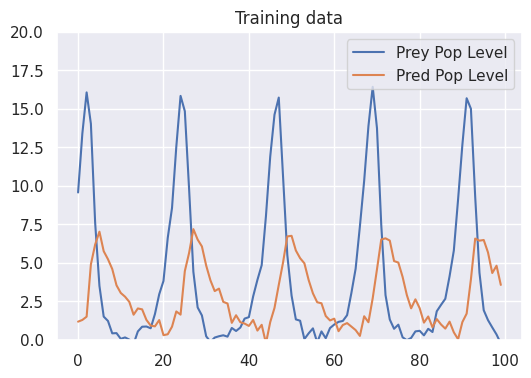

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(y[0], label="Prey Pop Level")
plt.plot(y[1], label="Pred Pop Level")
#plt.plot(y[:, 1] + y[:, 0], label="Total Population")
plt.ylim((0, 20))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [76]:
# Make batches

def batchify(data_x, data_y, input_timesteps=1):
    inputs = []
    outputs = []
    for i in range(len(data_x) - 1):
        inputs.append(torch.tensor([data_x[i], data_y[i]], dtype=t.float32))
        outputs.append(torch.tensor([data_x[i+1], data_y[i+1]], dtype=t.float32))

    inputs = torch.stack(inputs)
    outputs = torch.stack(outputs)
    return inputs, outputs

data_x, data_y = batchify(y[0], y[1])
data_y.shape

torch.Size([99, 2])

In [77]:
print(data_x.shape)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

torch.Size([99, 2])


In [92]:
out_features = 2
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True) # change to cfc, what could go wrong?
learn = SequenceLearner(ltc_model, lr=0.001)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


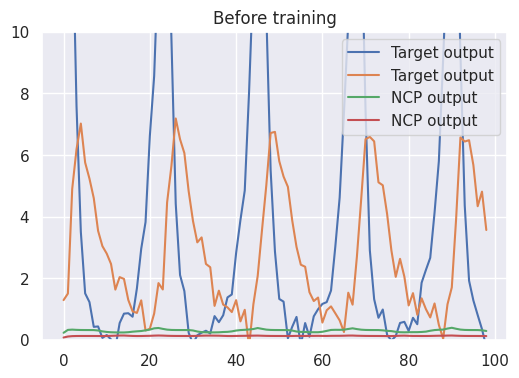

In [93]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y, label="Target output")
plt.plot(prediction, label="NCP output")
plt.ylim((0, 10))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [94]:
trainer.fit(learn, dataloader)


  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 1.5 K  | train
---------------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=400` reached.


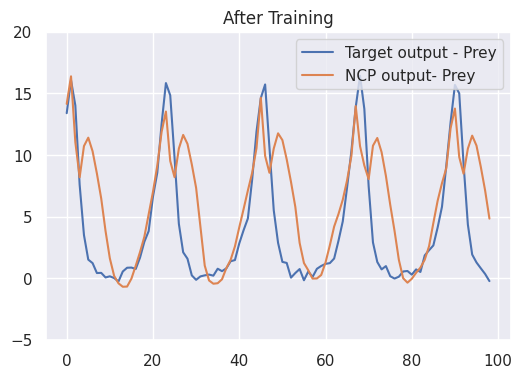

In [95]:
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()

plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 0], label="Target output - Prey")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 0], label="NCP output- Prey")
plt.ylim((-5, 20))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

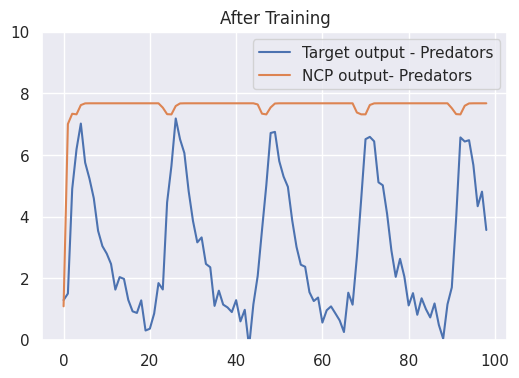

In [96]:
plt.figure(figsize=(6, 4))
plt.plot(data_y[:, 1], label="Target output - Predators")
#plt.plot(data_x[:, 0], label="Target output")
plt.plot(prediction[:, 1], label="NCP output- Predators")
plt.ylim((-0, 10))
plt.title("After Training")
plt.legend(loc="upper right")
plt.show()

:(